<h1>First full pipeline test on Antarctica</h1>
<p>

*Separate notebook created by Yara to avoid overwrites. We can merge this at the end.*

First install the extra `proplot` package needed for this notebook.

In [1]:
!pip install proplot 

In [9]:
from icepyx import icesat2data as ipd
import numpy as np
import os
import shutil
import h5py
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys
import pyproj
import proplot as plot

#%matplotlib widget
%matplotlib inline

## Download and extract histograms and other relevant parameters as npy arrays
**Skip to the next step if you have already saved the arrays previously.**

Extract histograms using the `get_hists.py` module. Using this script, we extract and save the relevant variables once and load them quickly instead of downloading and reading the HDF5 every time.

In [3]:
!python /home/jovyan/surface_classification/scripts/get_hists.py --HELP

Commandline options:
Type '--HELP' or '-H' flag for help.
Type '--DIR=' or '-D:' flag to specify data directory.
Type '--EXTENT=' or '-E:' flag to specify data spatial extent.
Type '--DATE=' or '-T:' to specify data date range.
Type '--USER=' or '-U:' flag to specify EarthData username.
Type '--EMAIL=' or '-E:' flag to specify EarthData email.
Type '--noDownload' or '-N' flag to skip downloading data if it's already there.
Done.


In [4]:
spatial_extent = [31.5, -70.56, 33.73, -69.29]
date_range = ['2020-03-30','2020-04-1']

In [5]:
!python /home/jovyan/surface_classification/scripts/get_hists.py --noDownload --EXTENT='31.5, -70.56, 33.73, -69.29' --DATE="'2020-03-30','2020-04-1'"

processed_ATL06_20200330121520_00600712_003_01.h5


## Load histograms and plot

In [6]:
data_dir = '/home/jovyan/data'
count = np.load(os.path.join(data_dir,'processed_ATL06_20200330121520_00600712_003_01_hist_gt1r.npy'))


Cropping the data far from surface in each histogram.

In [7]:
data = count[:, 200:550]

/srv/conda/envs/notebook/lib/python3.7/site-packages/ipykernel_launcher.py:3: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  This is separate from the ipykernel package so we can avoid doing imports until


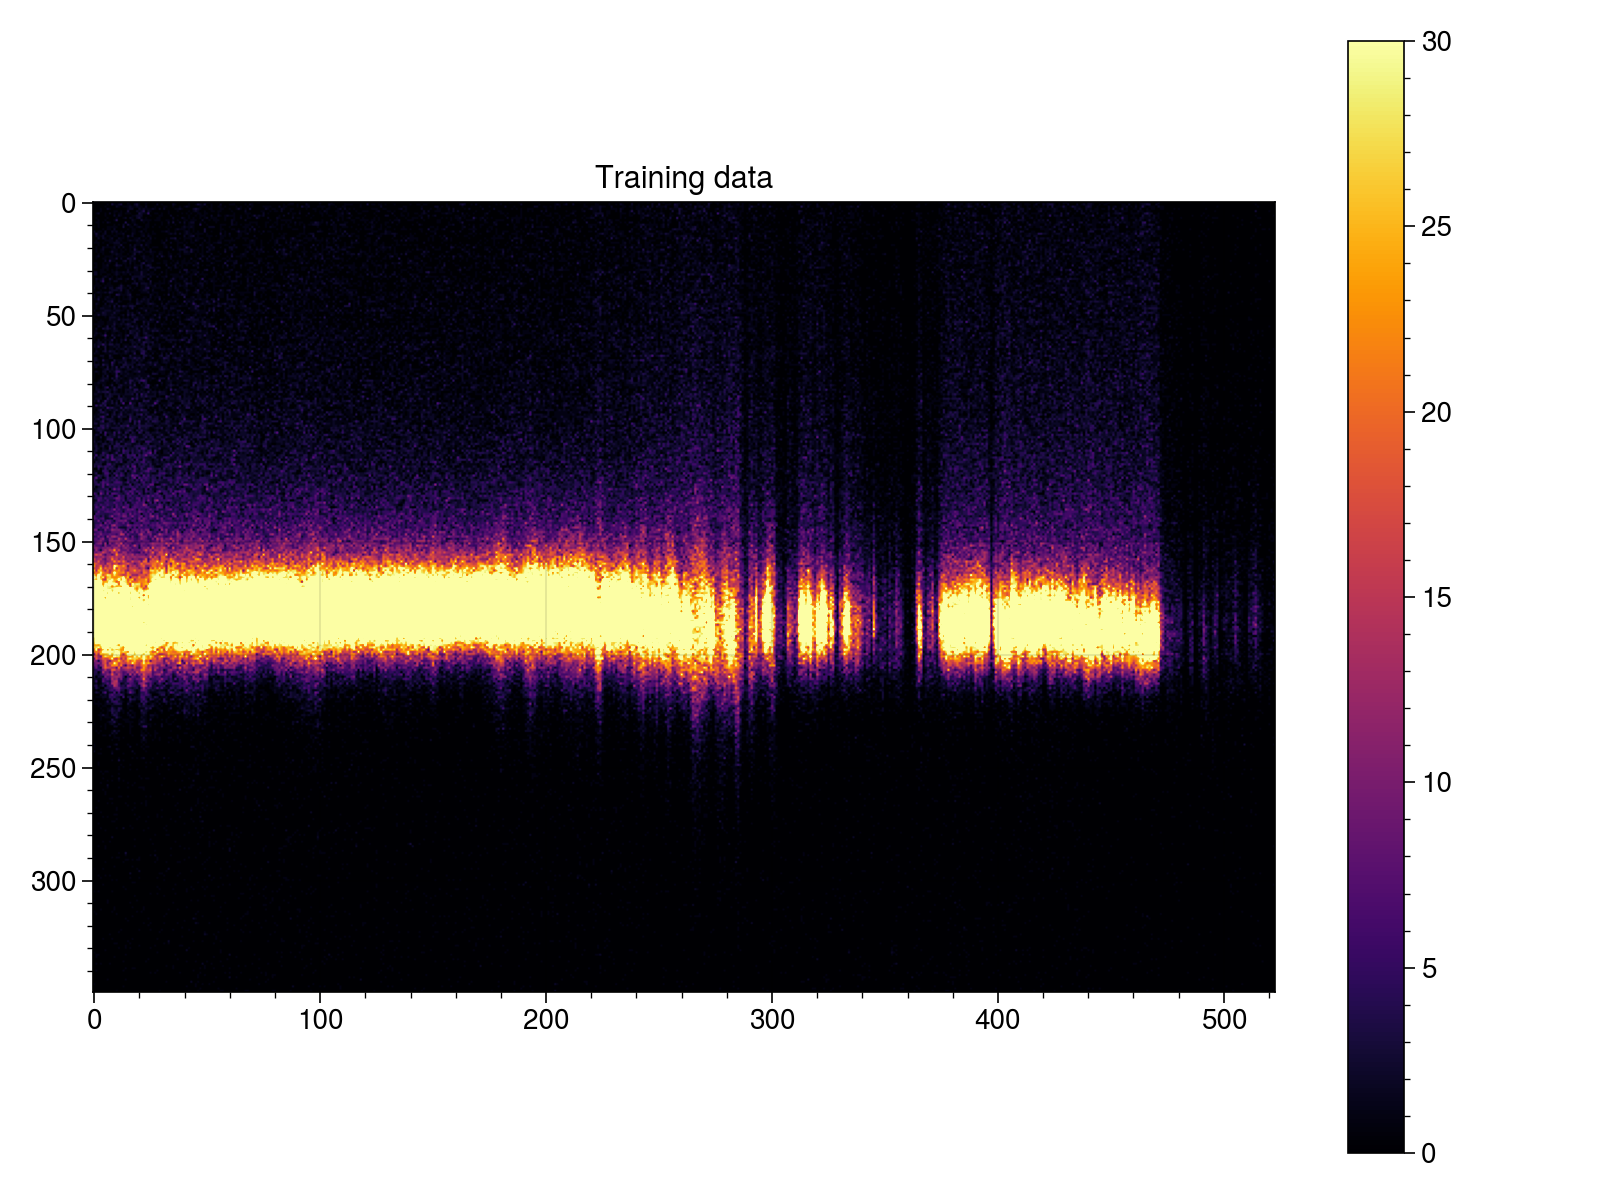

In [12]:
fig=plt.figure(figsize=(8,6))
plt.title("Training data")
ax = fig.add_subplot(111)
h = ax.imshow(np.transpose(data),vmin=0,vmax=30,cmap='inferno')
plt.colorbar(h)
plt.tight_layout()
plt.show()

<h2> Plotting track on map</a>

First load the `lon_mean` and `lat_mean` variables.

In [13]:
lon_mean = np.load(os.path.join(data_dir,'processed_ATL06_20200330121520_00600712_003_01_lon_mean_gt1r.npy'))
lat_mean = np.load(os.path.join(data_dir,'processed_ATL06_20200330121520_00600712_003_01_lat_mean_gt1r.npy'))

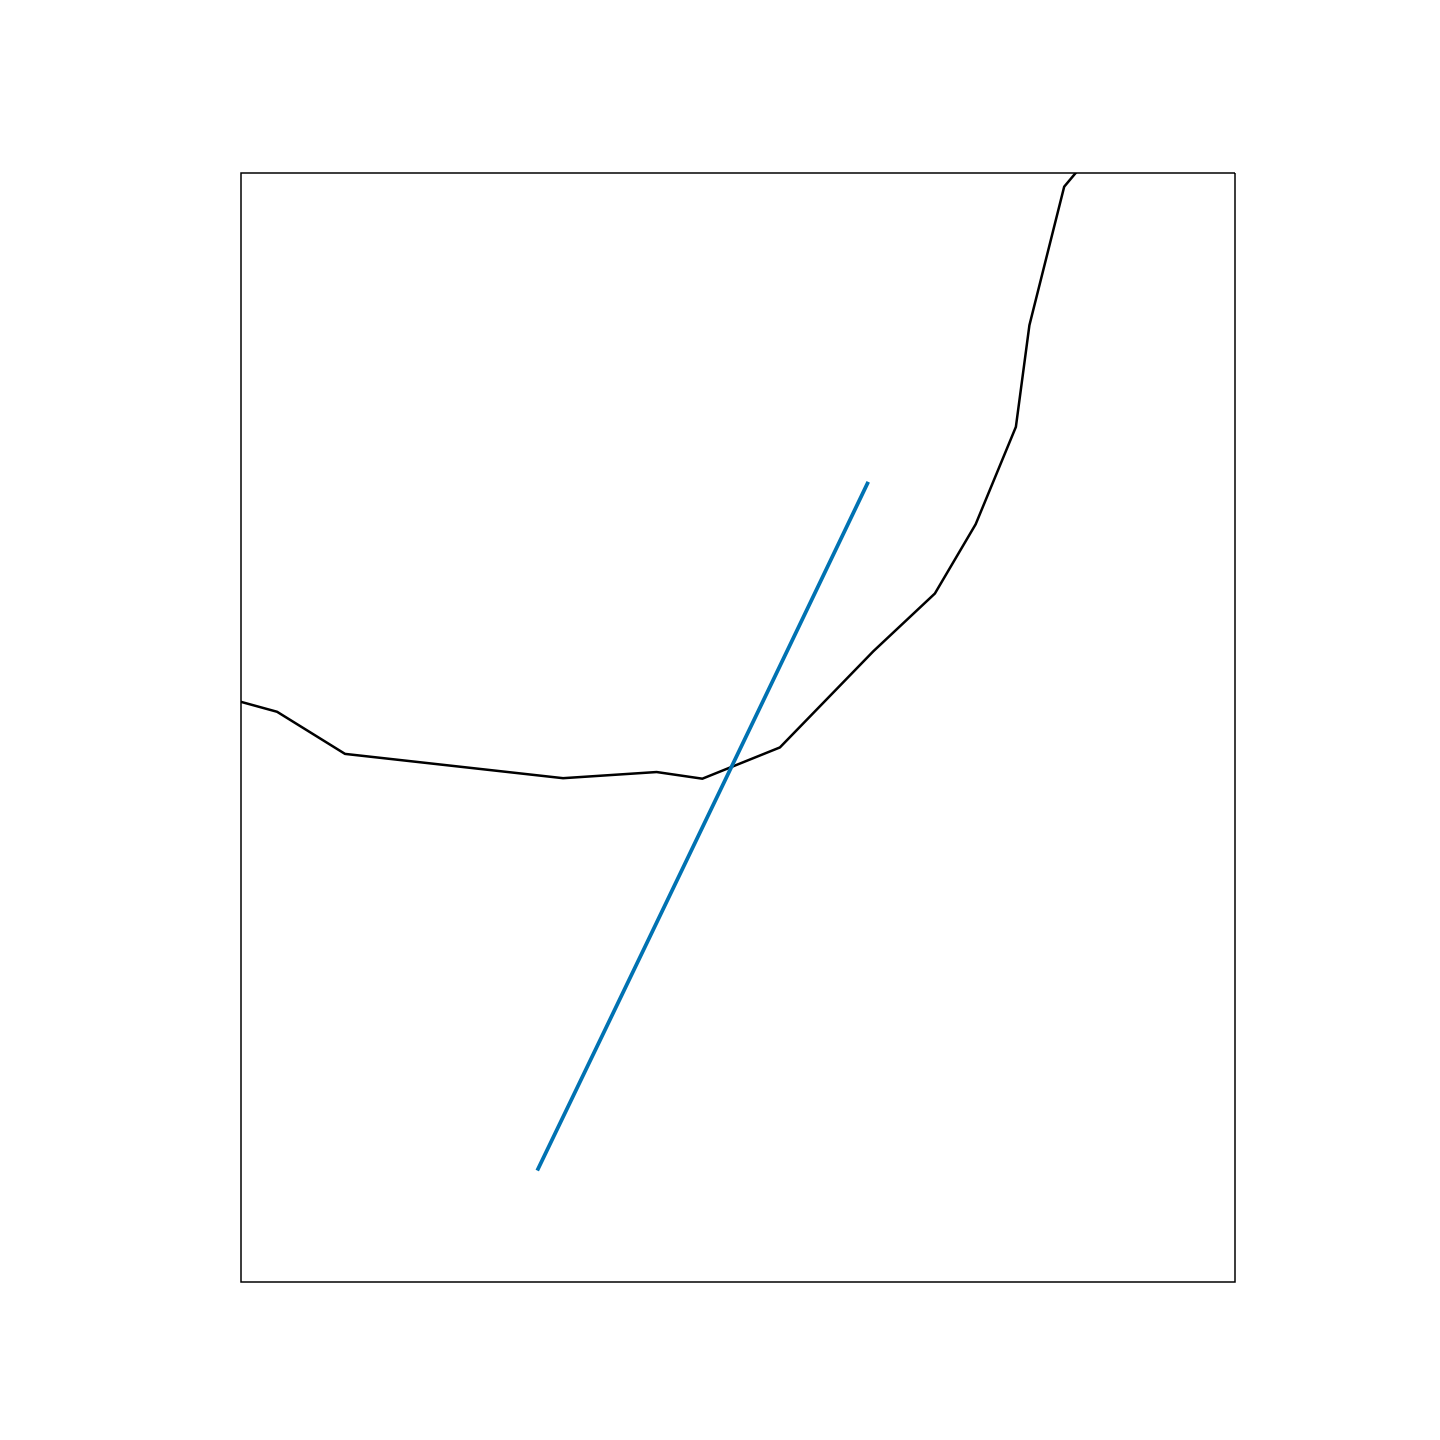

In [14]:
spatial_extent_ps = [spatial_extent[0], spatial_extent[2], spatial_extent[1], spatial_extent[3]]

## we will want to set colorbar parameters based on the chosen variable
vmin=0
vmax=6
ticks=np.arange(vmin,vmax+1,1)

plt.figure(figsize=(8,8), dpi= 90)
ax = plt.axes(projection=ccrs.SouthPolarStereo(central_longitude=0)) # choose polar sterographic for projection
ax.coastlines(resolution='50m', color='black', linewidth=1)
ax.set_extent(spatial_extent_ps, ccrs.PlateCarree())
plt.plot(lon_mean,lat_mean,transform=ccrs.PlateCarree())
plt.show()

Plot comparing mean_lon and mean_lon from histrograms with beam lat and lon.
Firt we load the parameters:

In [15]:
h_lon = np.load(os.path.join(data_dir,'processed_ATL06_20200330121520_00600712_003_01_h_lon_gt1r.npy'))
h_lat = np.load(os.path.join(data_dir,'processed_ATL06_20200330121520_00600712_003_01_h_lat_gt1r.npy'))

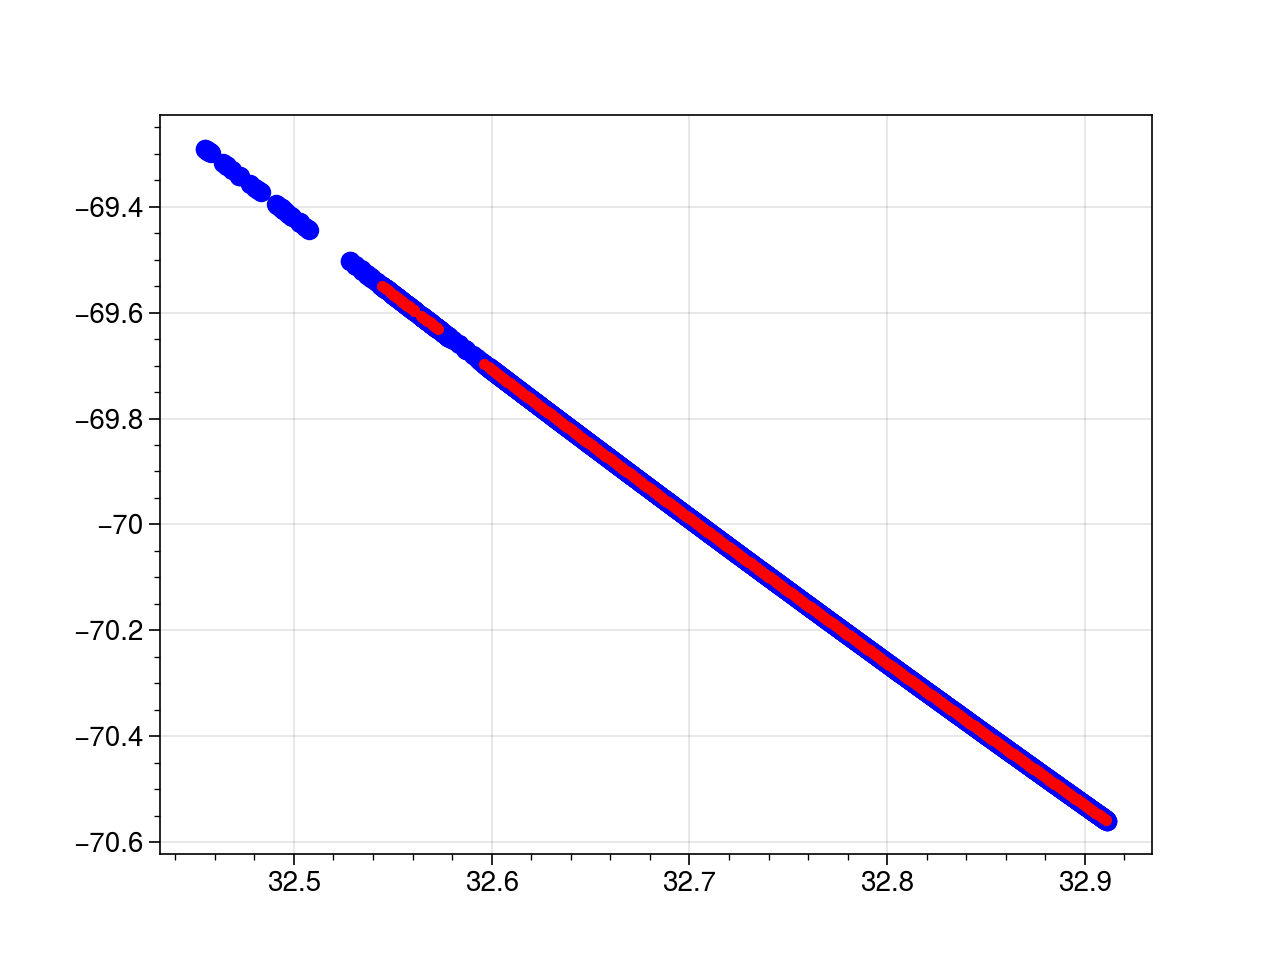

In [16]:
plt.figure()
plt.plot(h_lon,h_lat,'ob' )
plt.plot(lon_mean, lat_mean,'.r')
plt.show()

<h2>Unsupervised learning of ATL06 residual histograms</h2>

In [17]:
from sklearn.cluster import KMeans,AffinityPropagation,DBSCAN,OPTICS,MeanShift,AgglomerativeClustering,Birch

In [18]:
#-- K MEANS CLUSTERING

print("Training data shape: " + str(data.shape))

# Use int random_state in order to make centroid initialization deterministic
kmeans4 = KMeans(n_clusters=4, random_state=1).fit(data)
kmeans10 = KMeans(n_clusters=10, random_state=1).fit(data)
kmeans16 = KMeans(n_clusters=16, random_state=1).fit(data)

Training data shape: (523, 350)


In [19]:
#-- AFFINITY PROPAGATION CLUSTERING
affinity = AffinityPropagation(random_state=1).fit(data)

In [20]:
#-- DBSCAN
dbscan = DBSCAN(eps=40, min_samples=2).fit(data)

In [21]:
#-- OPTICS
optics = OPTICS(min_samples=2).fit(data)

In [22]:
#-- MEAN SHIFT
meanshift = MeanShift().fit(data)

In [23]:
#-- AgglomerativeClustering
agg4 = AgglomerativeClustering(n_clusters=4).fit(data)
agg16 = AgglomerativeClustering(n_clusters=16).fit(data)

In [24]:
#-- Birch
birch4 = Birch(n_clusters=4).fit(data)
birch16 = Birch(n_clusters=16).fit(data)

We plot the classified labels

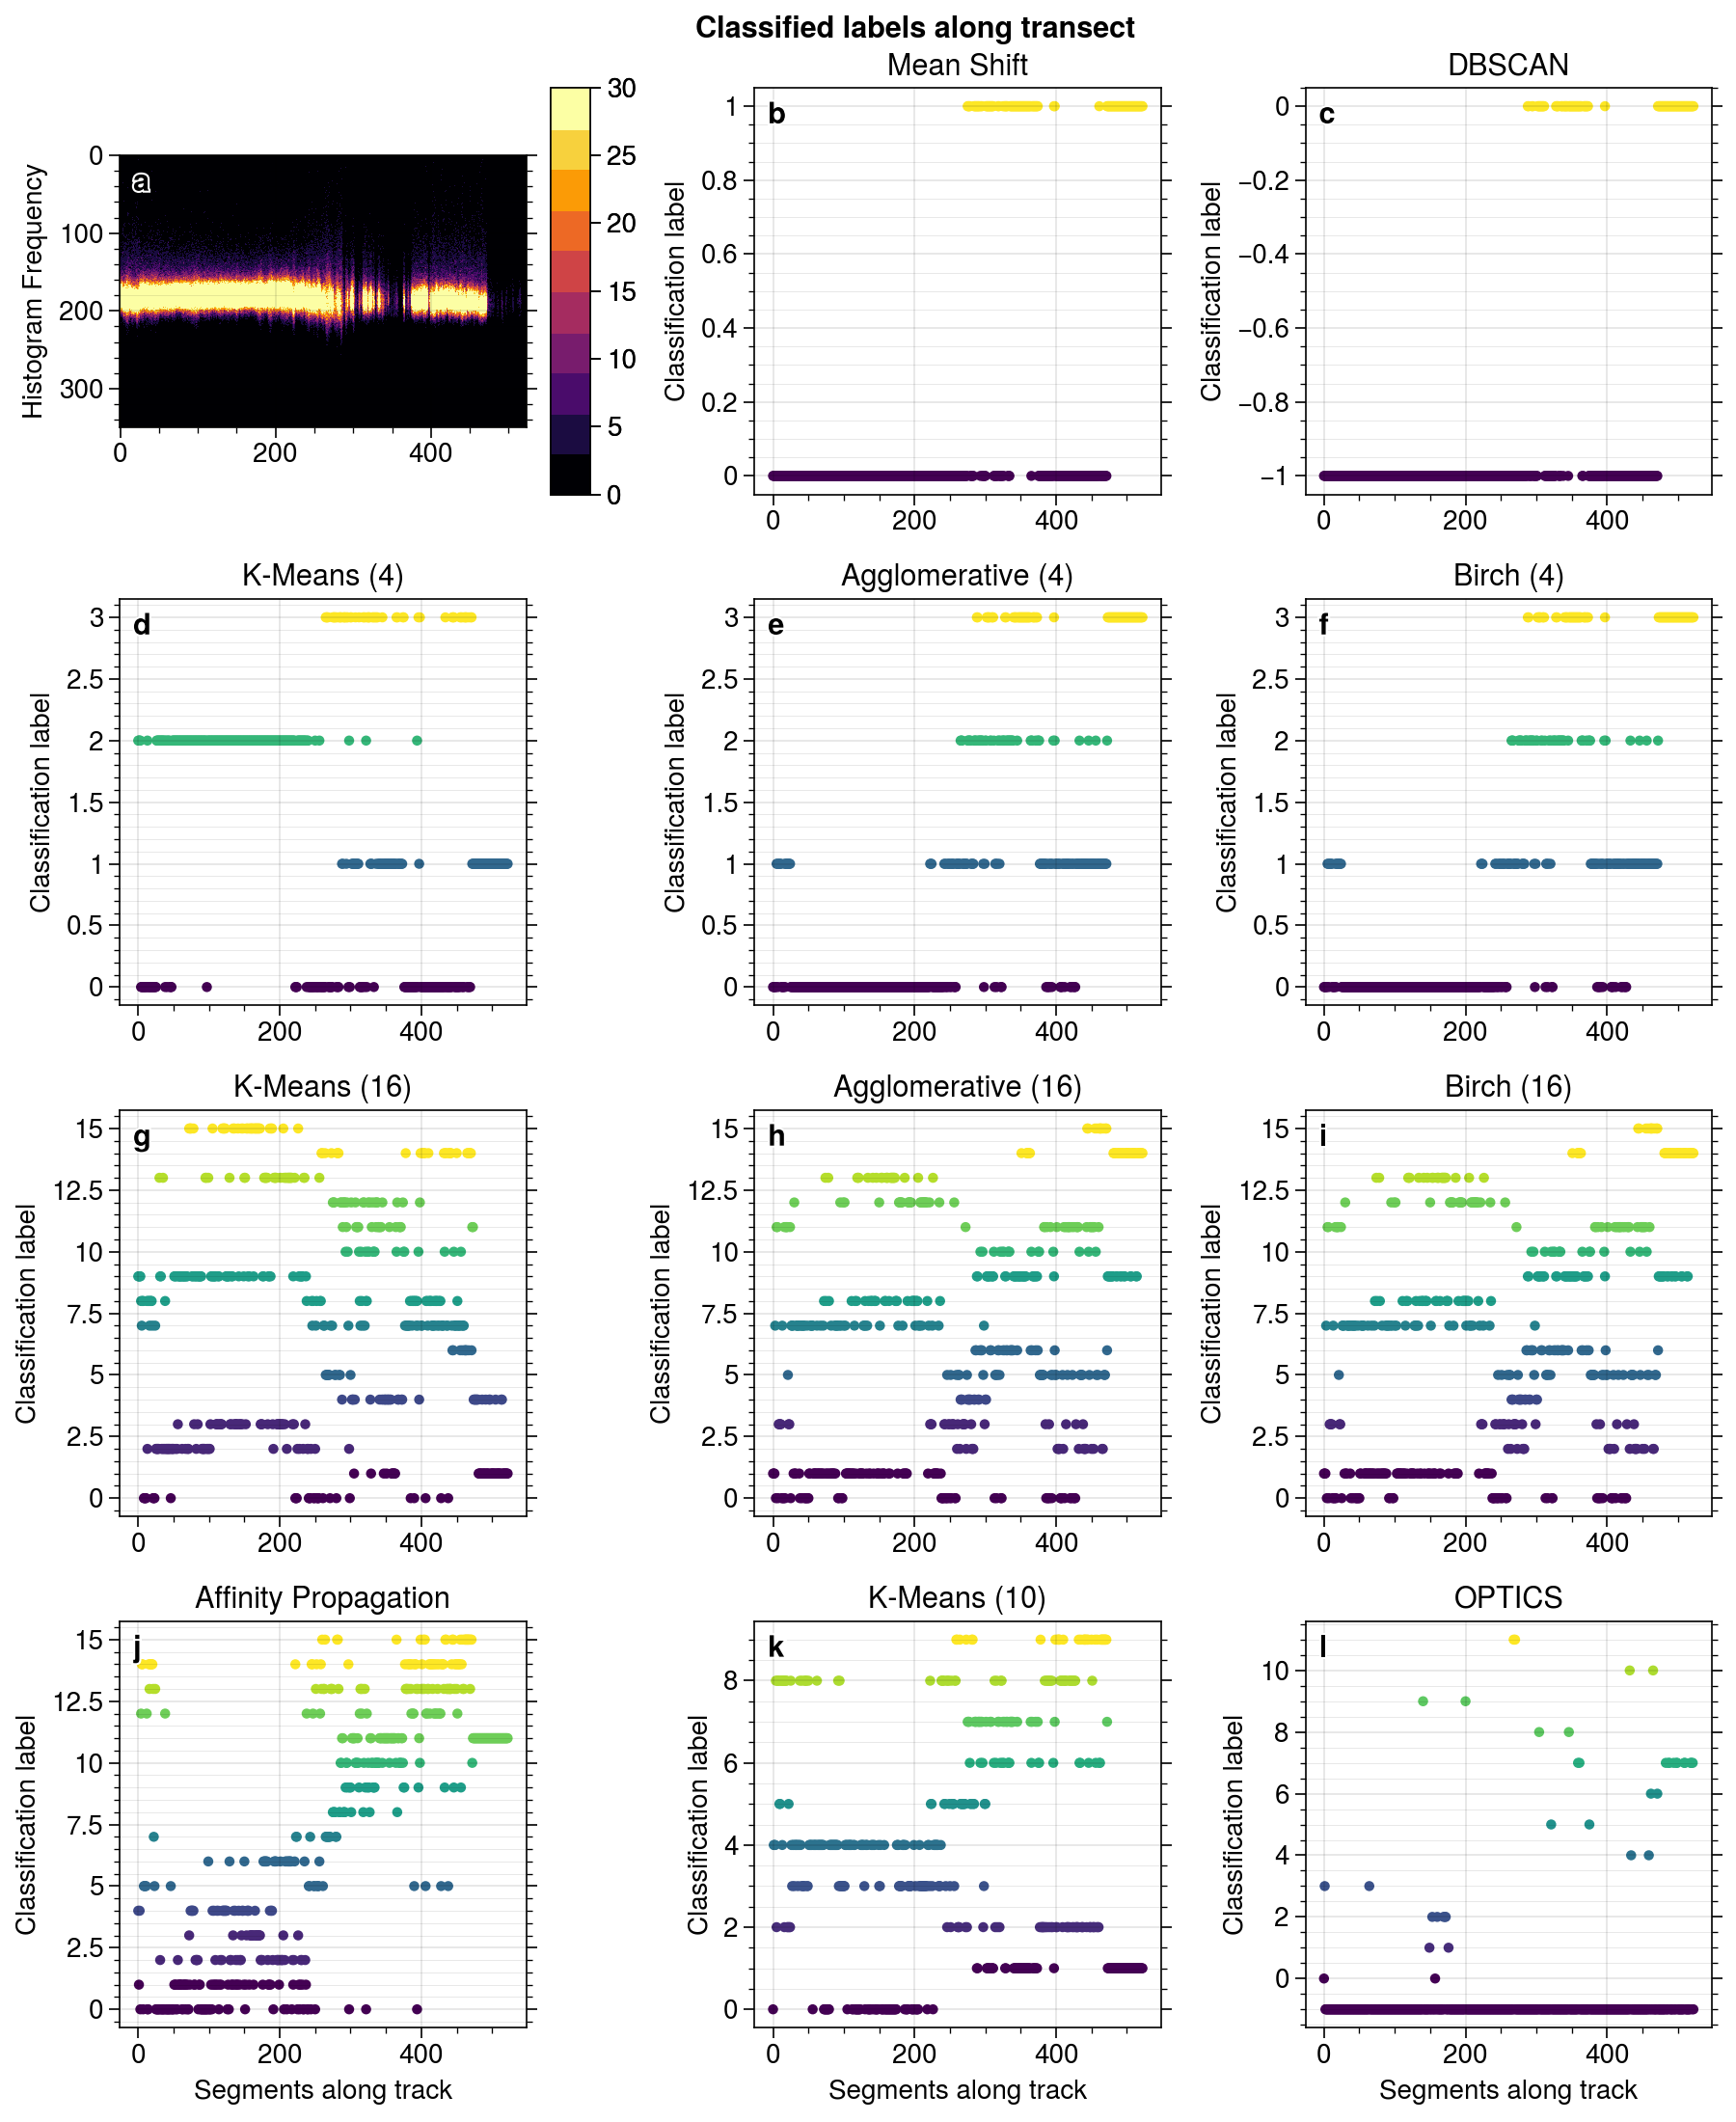

In [25]:
fig1, ax1 = plot.subplots(ncols=3, nrows=4, share=0, width=9, height=11)

fig1.suptitle("Classified labels along transect")

ax1.format(
        abc=True, abcloc='ul',
        ygridminor=True,
        ytickloc='both', yticklabelloc='left'
)

# Residual histograms
ax1[0,0].imshow(np.transpose(data),vmin=0,vmax=30,cmap='inferno')
ax1[0,0].colorbar(h)
ax1[0,0].set_ylabel('Histogram Frequency')


#-- MEAN SHIFT
ax1[0,1].scatter(range(0,data.shape[0]), meanshift.labels_, c=meanshift.labels_, s=10, cmap='viridis')
ax1[0,1].set_title('Mean Shift')
ax1[0,1].set_ylabel('Classification label')


#-- PLOT DBCAN and OPTICS
ax1[0,2].scatter(range(0,data.shape[0]), dbscan.labels_, c=dbscan.labels_, s=10, cmap='viridis')
ax1[0,2].set_title('DBSCAN')
ax1[0,2].set_ylabel('Classification label')


#----------------------
#-- row with 4 CLUSTERS
#----------------------
#-- k means
ax1[1,0].scatter(range(0,data.shape[0]), kmeans4.labels_, c=kmeans4.labels_, s=10,  cmap='viridis')
ax1[1,0].set_title('K-Means (4)')
ax1[1,0].set_ylabel('Classification label')

#-- AGG
ax1[1,1].scatter(range(0,data.shape[0]), agg4.labels_, c=agg4.labels_, s=10, cmap='viridis')
ax1[1,1].set_title('Agglomerative (4)')
ax1[1,1].set_ylabel('Classification label')

#-- BIRCH
ax1[1,2].scatter(range(0,data.shape[0]), birch4.labels_, c=birch4.labels_, s=10, cmap='viridis')
ax1[1,2].set_title('Birch (4)')
ax1[1,2].set_ylabel('Classification label')


#----------------------
#-- row with 16 CLUSTERS
#----------------------
#-- k means
ax1[2,0].scatter(range(0,data.shape[0]), kmeans16.labels_, c=kmeans16.labels_, s=10, cmap='viridis')
ax1[2,0].set_title('K-Means (16)')
ax1[2,0].set_ylabel('Classification label')


#-- AGG
ax1[2,1].scatter(range(0,data.shape[0]), agg16.labels_, c=agg16.labels_, s=10, cmap='viridis')
ax1[2,1].set_title('Agglomerative (16)')
ax1[2,1].set_ylabel('Classification label')

#-- Birch
ax1[2,2].scatter(range(0,data.shape[0]), birch16.labels_, c=birch16.labels_, s=10, cmap='viridis')
ax1[2,2].set_title('Birch (16)')
ax1[2,2].set_ylabel('Classification label')

#-- PLOT AFFINITY
ax1[3,0].scatter(range(0,data.shape[0]), affinity.labels_, c=affinity.labels_, s=10, cmap='viridis')
ax1[3,0].set_title('Affinity Propagation')
ax1[3,0].set_ylabel('Classification label')

#-- k means (10)
ax1[3,1].scatter(range(0,data.shape[0]), kmeans10.labels_, c=kmeans10.labels_, s=10, cmap='viridis')
ax1[3,1].set_title('K-Means (10)')
ax1[3,1].set_ylabel('Classification label')

#-- optics
ax1[3,2].scatter(range(0,data.shape[0]), optics.labels_, c=optics.labels_, s=10, cmap='viridis')
ax1[3,2].set_title('OPTICS')
ax1[3,2].set_ylabel('Classification label')


#-- label x axes
for i in range(3):
    ax1[3,i].set_xlabel('Segments along track')

# plt.tight_layout()
plt.show()

We display the labels on top of the raster map

In [26]:
data_root='/srv/tutorial-data/land_ice_applications/'

In [27]:
try:
    import pointCollection as pc
except Exception:
    !python3 -m pip install --user git+https://github.com/smithb/pointCollection.git
    import pointCollection as pc

In [ ]:
#-- Load in mosaic
spatial_extent = np.array(spatial_extent)
lat=spatial_extent[[1, 3, 3, 1, 1]]
lon=spatial_extent[[2, 2, 0, 0, 2]]
print(lat)
print(lon)
# project the coordinates to Antarctic polar stereographic
xy=np.array(pyproj.Proj(3031)(lon, lat))
# get the bounds of the projected coordinates 
XR=[np.nanmin(xy[0,:]), np.nanmax(xy[0,:])]
YR=[np.nanmin(xy[1,:]), np.nanmax(xy[1,:])]
MOA=pc.grid.data().from_geotif(os.path.join(data_root, 'MOA','moa_2009_1km.tif'), bounds=[XR, YR])

[-70.56 -69.29 -69.29 -70.56 -70.56]
[33.73 33.73 31.5  31.5  33.73]
{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([1114050., 1262050., 1773825., 1938825.]), 'origin': 'lower'}


Text(0.5, 1.0, 'Labeled transect (K-Means (4))')

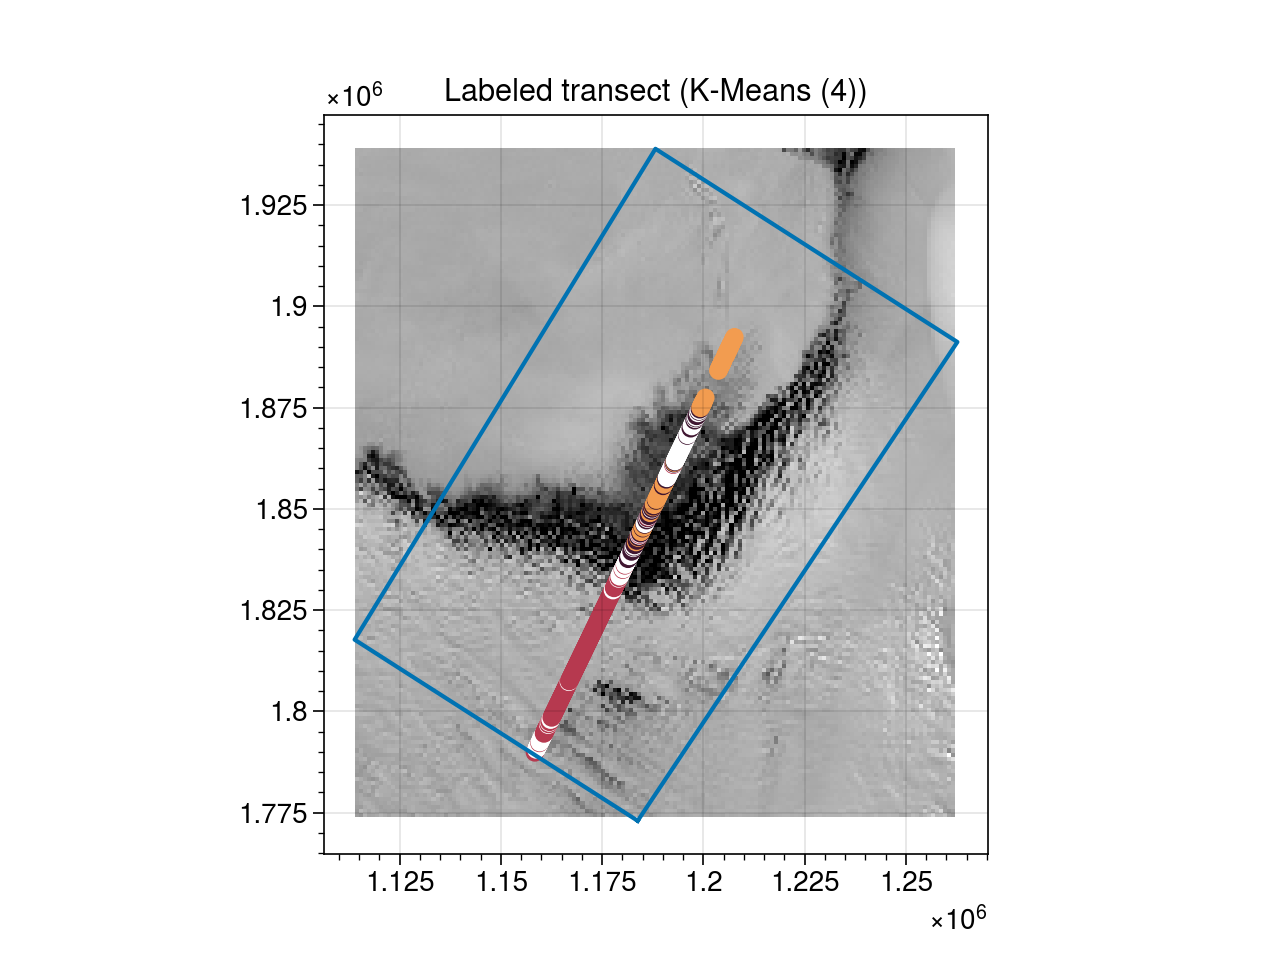

In [32]:
# show the mosaic:
plt.figure()
MOA.show(cmap='gray', clim=[14000, 17000])
ax.stock_img()
plt.plot(xy[0,:], xy[1,:])
# This still needs to be fixed in order to properly display the transect on the map
x_polar, y_polar=np.array(pyproj.Proj(3031)(lon_mean, lat_mean))
plt.scatter(x_polar, y_polar, c=kmeans4.labels_)
plt.title('Labeled transect (K-Means (4))')

Also plot the Agg results with the same number of clusters (4):

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([1114050., 1262050., 1773825., 1938825.]), 'origin': 'lower'}


Text(0.5, 1.0, 'Labeled transect (Agg (4))')

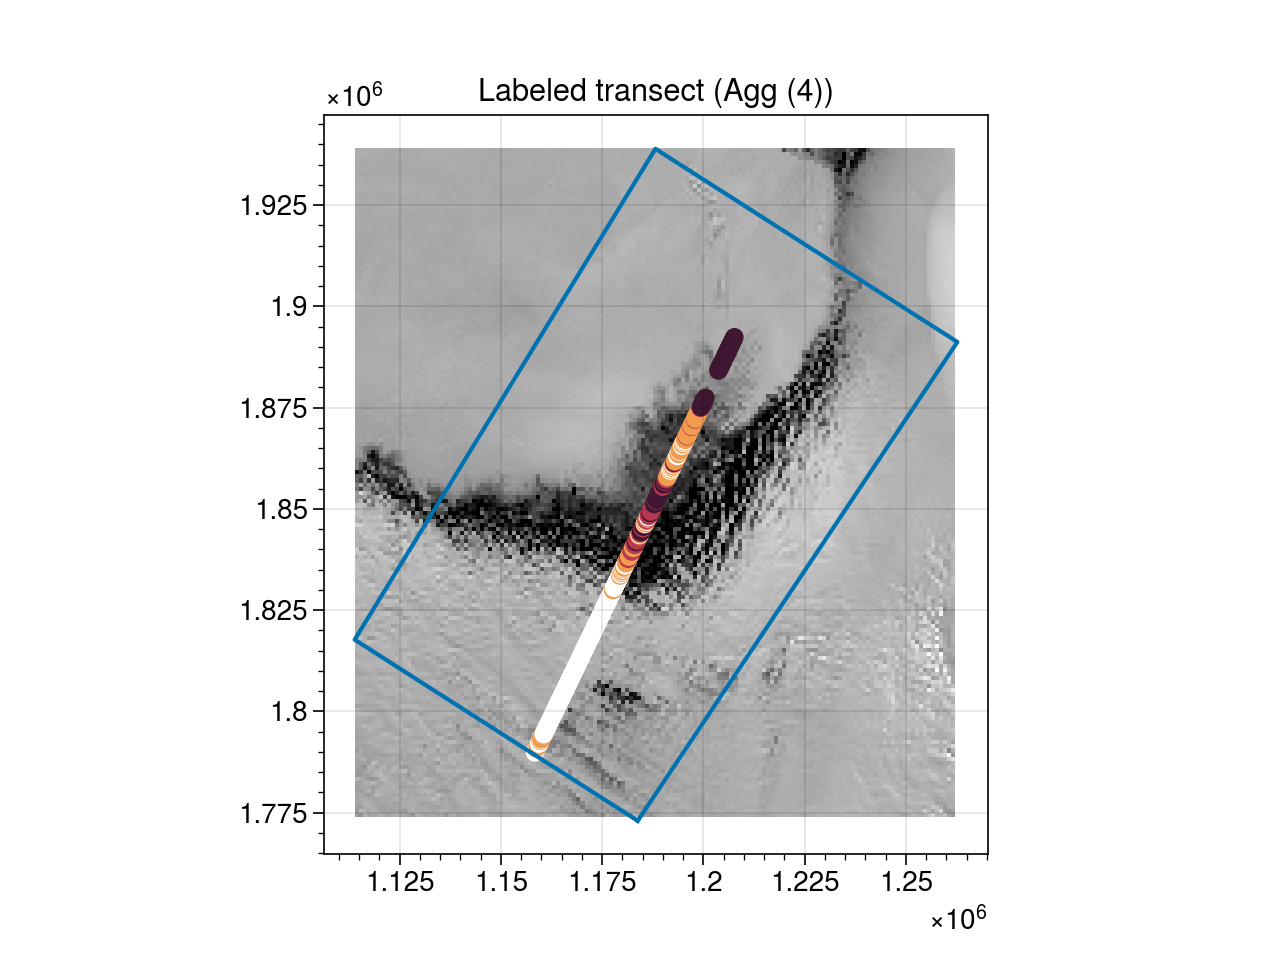

In [33]:
plt.figure()
MOA.show(cmap='gray', clim=[14000, 17000])
ax.stock_img()
plt.plot(xy[0,:], xy[1,:])
# This still needs to be fixed in order to properly display the transect on the map
x_polar, y_polar=np.array(pyproj.Proj(3031)(lon_mean, lat_mean))
plt.scatter(x_polar, y_polar, c=agg4.labels_)
plt.title('Labeled transect (Agg (4))')

{'cmap': 'gray', 'clim': [14000, 17000], 'extent': array([1114050., 1262050., 1773825., 1938825.]), 'origin': 'lower'}


Text(0.5, 1.0, 'Labeled transect (Birch (4))')

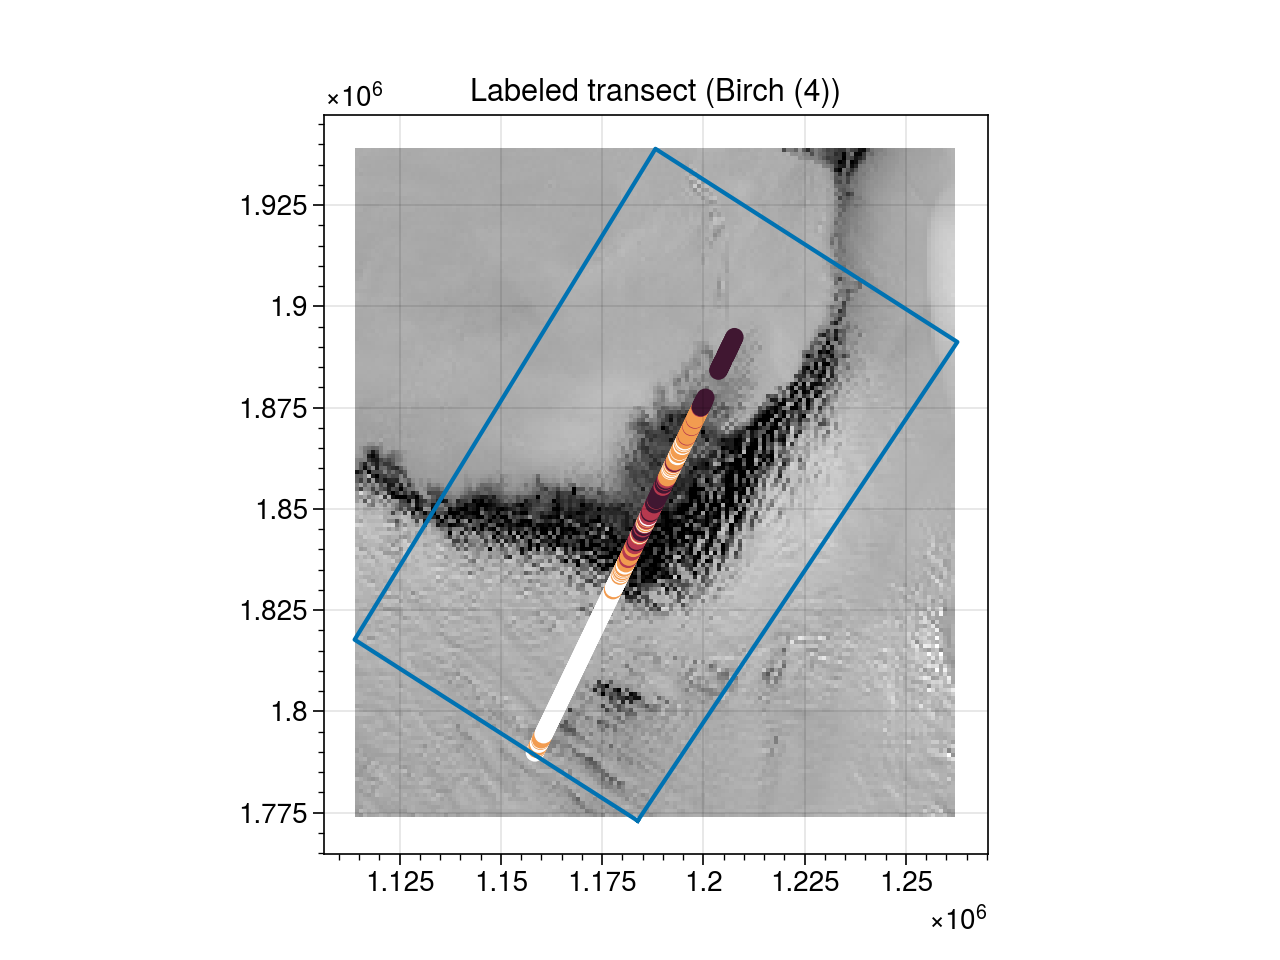

In [34]:
plt.figure()
MOA.show(cmap='gray', clim=[14000, 17000])
ax.stock_img()
plt.plot(xy[0,:], xy[1,:])
# This still needs to be fixed in order to properly display the transect on the map
x_polar, y_polar=np.array(pyproj.Proj(3031)(lon_mean, lat_mean))
plt.scatter(x_polar, y_polar, c=birch4.labels_)
plt.title('Labeled transect (Birch (4))')